In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from math import cos, sin, floor

# --- 1. Physics Configuration ---
g = 9.81
h = 1.0
x_f = 1.0
n_points = 100       # Increased resolution for better curvature calculation
mu = 0.0            # Coefficient of Kinetic Friction
x_nodes = np.linspace(0, x_f, n_points)


In [26]:
def solve_for_final_angle():
    """
    Numerically solves the transcendental equation for the final angle (theta_f)
    required for the cycloid to span equal horizontal and vertical distances (X=1, Y=1).
    
    The equation comes from setting the parametric form to the endpoint constraints:
    X(theta) = A(theta - sin(theta)) = 1
    Y(theta) = 1 - A(1 - cos(theta)) = 0  => A(1 - cos(theta)) = 1
    
    Substituting A gives: theta - sin(theta) = 1 - cos(theta)
    => f(theta) = theta - sin(theta) - 1 + cos(theta) = 0
    """
    # Define the function to solve f(theta) = 0
    def f(theta):
        return theta - sin(theta) - 1 + cos(theta)

    # Initial guess is important. We know the solution is between pi/2 (1.57) and pi (3.14).
    # A guess of 2.0 is reasonable.
    theta_f_solution = fsolve(f, 2.0)
    
    # fsolve returns an array, extract the value
    return theta_f_solution[0]

def generate_inverted_cycloid_points(num_points=100):
    """
    Generates points for an inverted cycloid (brachistochrone curve) 
    starting at (0, 1) and ending at (1, 0).
    """
    # 1. Solve for the final angle, theta_f
    theta_f = solve_for_final_angle()
    
    # 2. Calculate the scaling constant A (Radius of the rolling circle)
    # A = 1 / (1 - cos(theta_f))
    A = 1.0 / (1.0 - cos(theta_f))

    # 3. Generate 100 evenly spaced parameter values (theta)
    theta_values = np.linspace(0, theta_f, num_points)

    # 4. Define the parametric equations for the path (X, Y)
    # Standard cycloid starting at (0, 0) and moving downwards:
    # x = A * (theta - sin(theta))
    # y = A * (1 - cos(theta))
    
    # Inverted and translated path (starts at Y=1, ends at Y=0):
    # X(theta) = x
    # Y(theta) = 1 - y
    
    X = A * (theta_values - np.sin(theta_values))
    Y = 1.0 - (A * (1.0 - np.cos(theta_values)))

    # 5. Format and print the results
    points = np.column_stack((X, Y))
    return X, Y

In [27]:
# --- 2. The Physics Simulation (Loss Function) ---
def simulate_particle(y_interior):
    # Construct full coordinates
    y = np.concatenate(([h], y_interior, [0]))
    
    total_time = 0
    v = 0.0  # Initial velocity
    
    # We iterate through each segment to update velocity
    for i in range(len(y) - 1):
        # Geometry of the segment
        dy = y[i+1] - y[i]
        dx = x_nodes[i+1] - x_nodes[i]
        ds = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(-dy, dx) # Angle below horizontal (positive value)
        
        # 1. Estimate Curvature (R)
        # We need 3 points to estimate a circle, so we approximate R locally.
        # For simplicity in this discrete model, we often neglect the v^2/R term 
        # or treat segments as flat ramps (R -> infinity) to avoid numerical noise.
        # If we include v^2/R, it requires smooth 2nd derivatives. 
        # Let's stick to the dominant term N = mg cos(theta) for stability, 
        # but acknowledge the centripetal term effectively limits sharp turns.
        
        # Normal Force (approximate for discrete segments)
        # N = m * g * cos(theta)
        # Friction deceleration: a_fric = - mu * g * cos(theta)
        # Gravity acceleration: a_grav = g * sin(theta)
        
        # Calculate forces components along the path
        sin_theta = -dy / ds # Positive because dy is negative
        cos_theta = dx / ds
        
        accel_tangent = g * sin_theta - mu * g * cos_theta
        
        # Use kinematics: v_f^2 = v_i^2 + 2 * a * d
        v_squared_next = v**2 + 2 * accel_tangent * ds
        
        # Constraint: If particle stops, return infinite time (penalty)
        if v_squared_next <= 0.001:
            return 1e5 # Stuck!
            
        v_next = np.sqrt(v_squared_next)
        
        # Time for this segment (using average speed)
        v_avg = 0.5 * (v + v_next)
        total_time += ds / v_avg
        
        # Update velocity for next segment
        v = v_next
        
    return total_time

Optimization Complete. Best Time: 0.5832 s


<ipython-input-21-c7ba2c5d067a>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return theta - sin(theta) - 1 + cos(theta)


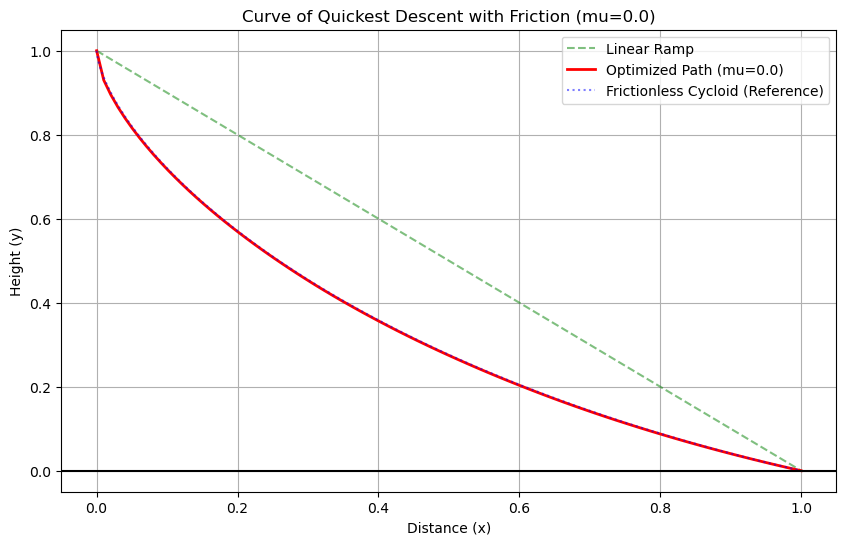

In [23]:
# --- 3. Optimization ---
# Initial Guess: Straight line
y_linear_guess = np.linspace(h, 0, n_points)
y_interior_guess = y_linear_guess[1:-1]

print(f"Simulating descent with Friction (mu={mu})...")

result = minimize(
    fun=simulate_particle,
    x0=y_interior_guess,
    method='L-BFGS-B',
    bounds=[(0, h)] * len(y_interior_guess)
)

print(f"Optimization Complete. Best Time: {result.fun:.4f} s")

# --- 4. Plotting ---
y_optimal = np.concatenate(([h], result.x, [0]))

plt.figure(figsize=(10, 6))
plt.plot(x_nodes, y_linear_guess, 'g--', label='Linear Ramp', alpha=0.5)
plt.plot(x_nodes, y_optimal, 'r-', label=f'Optimized Path (mu={mu})', linewidth=2)

# Standard Brachistochrone (Cycloid) for comparison - Frictionless reference
x_cyc, y_cyc = generate_inverted_cycloid_points(num_points=100)
plt.plot(x_cyc, y_cyc, 'b:', label='Frictionless Cycloid (Reference)', alpha=0.5)

plt.title(f"Curve of Quickest Descent with Friction (mu={mu})")
plt.xlabel("Distance (x)")
plt.ylabel("Height (y)")
plt.legend()
plt.grid(True)
plt.axhline(0, color='k')
plt.show()